In [ ]:
%matplotlib inline

In [18]:
import numpy as np  
import os.path as op
import matplotlib.pyplot as plt
import mne

from mne.datasets import sample
from mne import setup_volume_source_space, setup_source_space
from mne import make_forward_solution
from mne.minimum_norm import make_inverse_operator, apply_inverse
%gui qt
from mayavi import mlab
from nilearn.plotting import plot_stat_map
from nilearn.image import index_img
# Set dir
data_path = sample.data_path()
subject = 'sample'
data_dir = op.join(data_path, 'MEG', subject)
subjects_dir = op.join(data_path, 'subjects')
bem_dir = op.join(subjects_dir, subject, 'bem')

# Set file names
fname_aseg = op.join(subjects_dir, subject, 'mri', 'aseg.mgz')
fname_model = op.join(bem_dir, '%s-5120-bem.fif' % subject)
fname_bem = op.join(bem_dir, '%s-5120-bem-sol.fif' % subject)

fname_evoked = data_dir + '/sample_audvis-ave.fif'
fname_trans = data_dir + '/sample_audvis_raw-trans.fif'
fname_fwd = data_dir + '/sample_audvis-meg-oct-6-mixed-fwd.fif'
fname_cov = data_dir + '/sample_audvis-shrunk-cov.fif'

In [19]:
labels_vol = ['Left-Hippocampus']
sphere=(0,0,0,120)
src = setup_volume_source_space(subject, mri=fname_aseg, pos=2.0, sphere=sphere,
                                        volume_label=labels_vol, subjects_dir=subjects_dir, 
                                        verbose=True)
fwd = make_forward_solution(fname_evoked, fname_trans, src, fname_bem,
                            mindist=5.0,  
                            meg=True, eeg=False, n_jobs=1)
src_fwd = fwd['src']
n = sum(src_fwd[i]['nuse'] for i in range(len(src_fwd)))
print('the fwd src space contains %d spaces and %d points' % (len(src_fwd), n))
# Compute inverse solution 
snr = 3.0           
inv_method = 'MNE' # or MNE

lambda2 = 1.0 / snr ** 2
# Load data
condition = 'Left Auditory'
evoked = mne.read_evokeds(fname_evoked, condition=condition,
                          baseline=(None, 0))
noise_cov = mne.read_cov(fname_cov)
# Compute inverse operator
inverse_operator = make_inverse_operator(evoked.info, fwd, noise_cov,
                                         depth=None, fixed=False)

stcs = apply_inverse(evoked, inverse_operator, lambda2, inv_method,
                     pick_ori=None)

Sphere                : origin at (0.0 0.0 0.0) mm
              radius  : 120.0 mm
grid                  : 2.0 mm
mindist               : 5.0 mm
MRI volume            : C:\Users\PP255359\mne_data\MNE-sample-data\subjects\sample\mri\aseg.mgz

Setting up the sphere...
Surface CM = (   0.0    0.0    0.0) mm
Surface fits inside a sphere with radius  120.0 mm
Surface extent:
    x = -120.0 ...  120.0 mm
    y = -120.0 ...  120.0 mm
    z = -120.0 ...  120.0 mm
Grid extent:
    x = -122.0 ...  122.0 mm
    y = -122.0 ...  122.0 mm
    z = -122.0 ...  122.0 mm
1860867 sources before omitting any.
904009 sources after omitting infeasible sources.
796903 sources remaining after excluding the sources outside the surface and less than    5.0 mm inside.
Selecting voxels from Left-Hippocampus
450 sources remaining after excluding sources too far from VOI voxels
Adjusting the neighborhood info...
Reading C:\Users\PP255359\mne_data\MNE-sample-data\subjects\sample\mri\aseg.mgz...
Source space : MRI v

In [20]:
src = fwd['src']
# Export result as a 4D nifti object
img = stcs.as_volume(src,
                    mri_resolution=False)  # set True for full MRI resolution

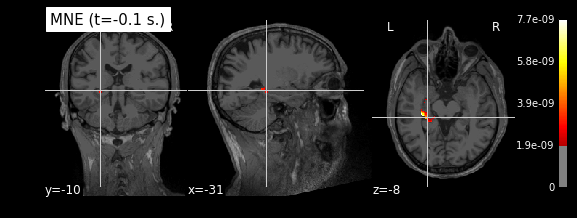

In [21]:
# Save it as a nifti file
# nib.save(img, 'mne_%s_inverse.nii.gz' % method)

t1_fname = data_path + '/subjects/sample/mri/T1.mgz'

# Plotting with nilearn ######################################################
plot_stat_map(index_img(img, 200), t1_fname, threshold=2*1e-9,
              title='%s (t=%.1f s.)' % (inv_method, stcs.times[61]))
plt.show()

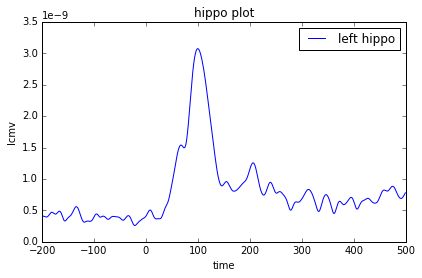

In [25]:
        
src = fwd['src']
fig,axes=plt.subplots(1)
axes.plot(1e3*stcs.times, np.mean(stcs.data, axis=0), label='left hippo')
#axes.plot(1e3*stc.times, right_hippo, 'k', label='right hippo')
axes.set(xlabel='time', ylabel='lcmv', title='hippo plot')

axes.legend()
mne.viz.tight_layout()
plt.show()
